# Solving combinatorial optimization problems using QAOA

In this tutorial, we introduce combinatorial optimization problems, explain approximate optimization algorithms, explain how the Quantum Approximate Optimization Algorithm (QAOA) works and present the implementation of an example that can be run on a simulator or on a real quantum system.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

## Combinatorial Optimization Problem

Combinatorial optimization problems involve finding an optimal object out of a finite set of objects. We would focus on problems that involve 
finding "optimal" bitstrings composed of 0's and 1's among a finite set of bitstrings. One such problem corresponding to a graph is the Max-Cut problem. 

### Max-Cut problem
A Max-Cut problem involves partitioning nodes of a graph into two sets, such that the number of edges between the sets is maximum. The example below
has a graph with four nodes and some of the ways in which it can be partitioned into two sets, "red" and "blue" is shown.

![](images/qaoa_maxcut.svg)

For 4 nodes, as each node can be assigned to either the "red" or "blue" sets, there are $2^4=16$ possible assigments, out of which we have to find one that gives maximum number of edges between the sets "red" and "blue". The number of such edges between two sets in the figure, as we go from left to right, are 0, 2, 2, and 4. We can see, after enumerating all possible $2^4=16$ assignments, that the rightmost figure is the assignment that gives the maximum number of edges between the two sets. Hence if we encode "red" as 0 and "blue" as 1, the bitstrings "0101" and "1010" that represent the assignment of nodes to either set are the solutions.   

As you may have realized, as the number of nodes in the graph increases, the number of possible assignments 
that you have to examine to find the solution increases exponentially.

## QAOA

QAOA (Quantum Approximate Optimization Algorithm) introduced by Farhi et al.[1] is a quantum algorithm that attempts to 
solve such combinatorial problems.<br> 

It is a variational algorithm that uses a unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ characterized by the parameters 
$(\boldsymbol{\beta}, \boldsymbol{\gamma})$ to prepare a quantum state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$. 
The goal of the algorithm
is to find optimal parameters $(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt})$ such that the 
quantum state $\lvert \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle$ encodes the solution to the problem. 

The unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ has a specific form and is composed of two unitaries 
$U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$ and $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$
where $H_B$ is the mixing Hamiltonian and $H_P$ is the problem Hamiltonian. Such a choice of unitary drives its inspiration 
from a related scheme called quantum annealing.

The state is prepared by applying these unitaries as alternating blocks of the two unitaries applied $p$ times such that 

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) 
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}} 
\lvert \psi_0 \rangle$$

where $\lvert \psi_0 \rangle$ is a suitable initial state. 

We will demonstrate these steps using the Max-Cut problem discussed above. For that we would first define
the underlying graph of the problem shown above.

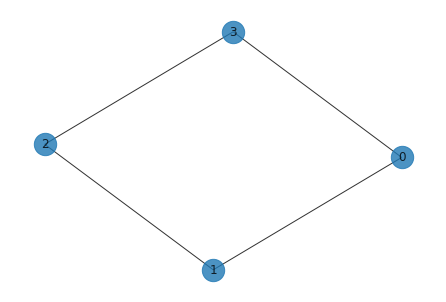

In [2]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

The problem Hamiltonian specific to the Max-Cut problem up to a constant here is:

$$
H_P = \frac{1}{2}\big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) + 
        \frac{1}{2}\big(I_0 \otimes Z_1 \otimes Z_2 \otimes I_3\big) +
        \frac{1}{2}\big(Z_0 \otimes I_1 \otimes I_2 \otimes Z_3\big) +
        \frac{1}{2}\big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3\big)
$$

To contruct such a Hamiltonian for a problem, one needs to follow a few steps that we'll cover in later sections of this page.

The mixer Hamiltonian $H_B$ is usually of the form:

$$
H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \big) + 
      \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \big)
$$

As individual terms in the summation of $H_P$ and $H_B$ both commute, we can write the unitaries as:

$$ U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0}e^{-i \beta X_1}e^{-i \beta X_2}e^{-i \beta X_3}.$$

Notice that each term in the product above corresponds to an X-rotation on each qubit. And we can write $U(H_P)$ as:

$$ U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1}e^{-i \gamma Z_1 Z_2}e^{-i \gamma Z_2 Z_3}e^{-i \gamma Z_0 Z_3}$$

Let's now examine what the circuits of the two unitaries look like. 

### The Mixing Unitary

<ipython-input-3-3122dc3f04ac>:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


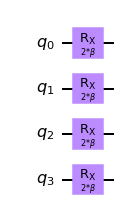

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

### The Problem Unitary

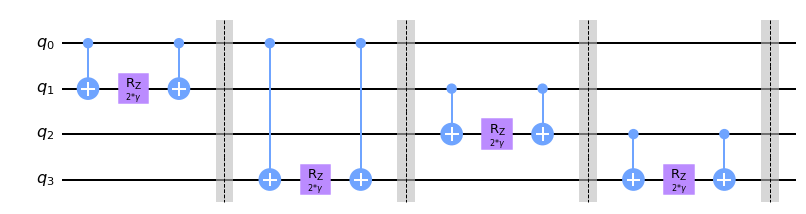

In [4]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

### The Initial State

The initial state used during QAOA is usually an equal superposition of all the basis states i.e.

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

Such a state, when number of qubits is 4 ($n=4$), can be prepared by applying Hadamard gates starting from an all zero state as shown in 
the circuit below. 

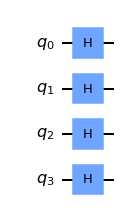

In [5]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

### The QAOA circuit

So far we have seen that the preparation of a quantum state during QAOA is composed of three elements
- Preparing an initial state
- Applying the unitary $U(H_P) = e^{-i \gamma H_P}$ corresponding to the problem Hamiltonian
- Then, applying the mixing unitary $U(H_B) = e^{-i \beta H_B}$

Let's see what it looks like for the example problem:

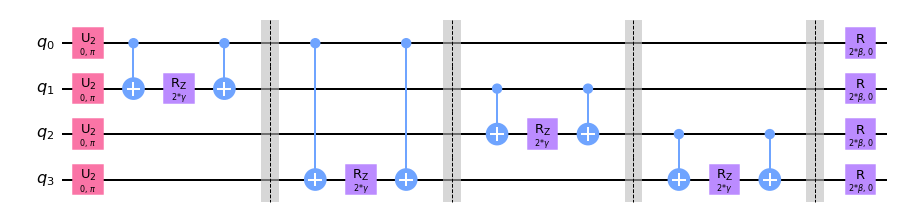

In [6]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

The next step is to find the optimal parameters $(\boldsymbol{\beta_{opt}}, \boldsymbol{\gamma_{opt}})$ such that the expectation value

$$ \langle \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rvert H_P \lvert 
\psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle $$

is minimized. Such an expectation can be obtained by doing measurement in the Z-basis. We use a classical optimization algorithm to find the optimal parameters. Following steps are involved as shown in the schematic 
<img src="images/QAOA_schematic.png" width="400" height="200" class="center">

1. Initialize $\boldsymbol{\beta}$ and $\boldsymbol{\gamma}$ to suitable real values.
2. Repeat until some suitable convergence criteria is met:
    1. Prepare the state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ using qaoa circuit
    2. Measure the state in standard basis
    3. Compute $ \langle \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rvert H_P \lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $ 
    4. Find new set of parameters $(\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})$ using a classical optimization algorithm
    5. Set current parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ equal to the new parameters 
      $(\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})$

The code below implements the steps mentioned above.

In [7]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [8]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

Note that different choices of classical optimizers are present in qiskit. We choose [COBYLA](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py) as our classical optimization algorithm here.

### Analyzing the result

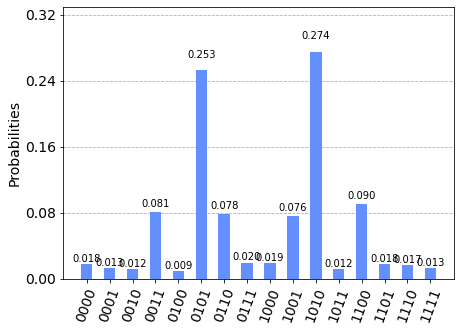

In [9]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

As we notice that the bitstrings "0101" and "1010" have the highest probability and are indeed the assignments of the graph (we started with) that gives 4 edges between the two partitions. 

## Appendix

### 1. Constructing Problem Hamiltonian <a id='Constructing Hamiltonian'></a>

Any maximization problem can be cast in terms of a minimization problem and vice versa. Hence the general form a combinatorial optimization problem is given by



$$ \text{maximize } \;\;      C(x)$$




$$ \text{subject to } \;\; x \in S $$



where $x \in S$, is a discrete variable and $C : D \rightarrow \mathbb{R}$ is the cost function, that maps from some domain $S$ in to the real numbers $\mathbb{R}$. The variable $x$ can be subject to a set of constraints and lies within the set $S \subset D$ of feasible points.

In binary combinatorial optimization problems, the cost function $C$ can typically be expressed as a sum of terms that only involve a subset $Q \subset[n]$ of the $n$ bits in the string $x \in \{0,1\}^n$ and is written in the canonical form



$$ C(x) = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \prod_{i\in Q} x_i \; \prod_{j\in \overline{Q}} (1- x_j), $$



where $x_i \in \{0,1\}$ and $w_{(Q,\overline{Q})}\in \mathbb{R}$. We want to find the n-bit string $x$ for which $C(x)$ is the maximal.

#### 1.1 Diagonal Hamiltonians

This cost function can be mapped to a Hamiltonian that is diagonal in the computational basis. Given the cost-function $C$ this Hamiltonian is then written as



$$ H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x| $$



where $x \in \{0,1\}^n$ labels the computational basis states $|x \rangle \in \mathbb{C}^{2^n}$. If the cost function only has at most weight $k$ terms, i.e. when only $Q$ contribute that involve at most $Q \leq k$ bits, then this diagonal Hamiltonian is also only a sum of weight $k$ Pauli $Z$ operators.

The expansion of $H$ in to Pauli $Z$ operators can be obtained from the canonical expansion of the cost-function $C$ by substituting for every binary variable $x_i \in \{0,1\}$ the matrix $x_i \rightarrow 2^{-1}(1 - Z_i)$. Here $Z_i$ is read as the Pauli $Z$ operator that acts on qubit $i$ and trivial on all others, i.e.



$$ Z_i = \left(\begin{array}{cc} 1 & 0 \\ 0 & -1 \end{array}\right). $$



This means that the spin Hamiltonian encoding the classical cost function is written as a $|Q|$ - local quantum spin Hamiltonian only involving Pauli $Z$- operators. 



$$ H = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \frac{1}{2^{|Q| + |\overline{Q}|}}\prod_{i\in Q} \left(1 - Z_i\right) \; \prod_{j\in \overline{Q}} \left(1 + Z_j\right).$$



Now, we will assume that only a few (polynomially many in $n$) $w_{(Q,\overline{Q})}$ will be non-zero. Moreover we will assume that the set $|(Q,\overline{Q})|$ is bounded and not too large. This means we can write the cost function as well as the Hamiltonian $H$ as the sum of $m$ local terms $\hat{C}_k$, 



$$ H = \sum_{k = 1}^m \hat{C}_k, $$



where both $m$ and the support of $\hat{C}_k$ is reasonably bounded.

### 2 Examples: <a id='examples'></a>

We consider 2 examples to illustrate combinatorial optimization problems. We will only implement the first example as in Qiskit, but provide a sequence of exercises that give the instructions to implement the second example as well.  


#### 2.1 (weighted) $MAXCUT$

Consider an $n$-node non-directed graph *G = (V, E)* where *|V| = n* with edge weights $w_{ij}>0$, $w_{ij}=w_{ji}$, for $(i,j)\in E$. A cut is defined as a partition of the original set V into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, *crossing* the cut. By assigning $x_i=0$ or $x_i=1$ to each node $i$, one tries to maximize the global profit function (here and in the following summations run over indices 0,1,...n-1)



$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j).$$



To simplify notation, we assume uniform weights $ w_{ij} = 1$ for $(i,j) \in E$. In order to find a solution to this problem on a quantum computer, one needs first to map it to a diagonal  Hamiltonian as discussed above. We write the sum as a sum over edges in the set $(i,j) = E$ 



$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j)  = \sum_{(i,j) \in E} \left( x_i (1-x_j) + x_j (1-x_i)\right)$$



To map it to a spin Hamiltonian, we make the assignment $x_i\rightarrow (1-Z_i)/2$, where $Z_i$ is the Pauli Z operator that has eigenvalues $\pm 1$ and obtain $X \rightarrow H$



$$ H = \sum_{(j,k) \in E} \frac{1}{2}\left(1 - Z_j Z_k \right).$$



This means that the Hamiltonian can be written as a sum of $m = |E|$ local terms $\hat{C}_e = \frac{1}{2}\left(1 - Z_{e1}Z_{e2}\right)$ with $e = (e1,e2) \in E$. 


#### 2.2 Constraint satisfaction problems and $MAX \; 3-SAT$.

Another example of a combinatorial optimization problem is $3-SAT$. Here the cost function $C(\textbf{x}) = \sum_{k = 1}^m c_k(\textbf{x})$ is a sum of clauses $c_k(\textbf{x})$ that constrain the values of $3$ bits of some $\textbf{x} \in \{0,1\}^n$ that participate in the clause. Consider for instance this example of a $3-SAT$ clause 



$$ c_1(\textbf{x}) = (1-x_1)(1-x_3)x_{132} $$



for a bit string $\textbf{x} \in \{0,1\}^{133}$. The clause can only be satisfied by setting the bits $x_1 = 0$,$x_3 = 0$ and $x_{132} = 1$. The $3-SAT$ problem now asks whether there is a bit string that satisfies all of the $m$ clauses or whether no such string exists. This decision problem is the prime example of a problem that is $NP$-complete.  

The closely related optimization problem $MAX \; 3-SAT$ asks to find the bit string $\textbf{x}$ that satisfies the maximal number of of clauses in $C(\textbf{x})$. This can of course be turned again in to a decision problem if we ask where there exists a bit string that satisfies more than $\tilde{m}$ of the $m$ clauses, which is again $NP$-complete.

### 3. Approximate optimization algorithms <a id='approximateOPT'></a>

Both the previously considered problems $MAXCUT$ and $MAX \; 3-SAT$ are actually known to be a NP-hard problems [3](#references). In fact it turns out that many combinatorial optimization problems are computationally hard to solve in general. In light of this fact, we can't expect to find a provably efficient algorithm, i.e. an algorithm with polynomial runtime in the problem size, that solves these problems. This also applies to quantum algorithms. There are two main approaches to dealing with such problems. First approach is approximation algorithms that are guaranteed to find solution of specified quality in polynomial time. The second approach are heuristic algorithms that don't have a polynomial runtime guarantee but appear to perform well on some instances of such problems. 

Approximate optimization algorithms are efficient and provide a provable guarantee on how close the approximate solution is to the actual optimum of the problem. The guarantee typically comes in the form of an approximation ratio, $\alpha \leq 1$. A probabilistic approximate optimization algorithm guarantees that it produces a bit-string $\textbf{x}^* \in \{0,1\}^n$ so that *with high probability* we have that with a positive $C_{max} = \max_{\textbf{x}}C(\textbf{x})$ 



$$ C_{max} \geq C(\textbf{x}^*) \geq \alpha C_{max}. $$



For the $MAXCUT$ problem there is a famous approximate algorithm due to Goemans and Williamson [2](#references) . This algorithm is based on an SDP relaxation of the original problem combined with a probabilistic rounding technique that yields an with high probability approximate solution $\textbf{x}^*$ that has an approximation ratio of $\alpha \approx 0.878$. This approximation ratio is actually believed to optimal so we do not expect to see an improvement by using a quantum algorithm.

### 4. The QAOA algorithm <a id="QAOA"></a>
The Quantum approximate optimization algorithm (QAOA) by Farhi, Goldstone and Gutmann [1](#references) is an example of a heuristic algorithm. Unlike Goemans-Williamson algorithm, QAOA does not come with performance guarantees.
QAOA takes the approach of classical approximate algorithms and looks for a quantum analogue that will likewise produce a classical bit string $x^*$ that with high probability is expected to have a good approximation ratio $\alpha$. Before discussing the details, let us first present the general idea of this approach. 

#### 4.1 Overview:

We want to find a quantum state $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$, that depends on some real parameters $\vec{\gamma},\vec{\beta} \in \mathbb{R}^p$, which has the property that it maximizes the expectation value with respect to the problem Hamiltonian $H$. Given this trial state we search for parameters $\vec{\gamma}^*,\vec{\beta}^*$ that maximize $F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle$. 

Once we have such a state and the corresponding parameters we prepare the state $|\psi_p(\vec{\gamma}^*,\vec{\beta}^*)\rangle$ on a quantum computer and measure the state in the $Z$ basis $|x \rangle = |x_1,\ldots x_n \rangle$ to obtain a random outcome $x^*$. 

We will see that this random $x^*$ is going to be a bit string that is with high probability close to the expected value $M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)$. Hence, if $M_p$ is close to $C_{max}$ so is $C(x^*)$.

#### 4.2 The components of the QAOA algorithm.

#### 4.2.1 The QAOA trial state <a id="section_421"></a>
Central to QAOA is the trial state $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ that will be prepared on the quantum computer. Ideally we want this state to give rise to a large expectation value $F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ with respect to the problem Hamiltonian $H$. In Farhi [1](#references), the trial states $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ are constructed from the problem Hamiltonian $H$ together with single qubit Pauli $X$ rotations. That means, given a problems Hamiltonian 


$$ H = \sum_{k = 1}^m \hat{C}_k $$

 
diagonal in the computational basis and a transverse field Hamiltonian


$$ B = \sum_{i = 1}^n X_i $$


the trial state is prepared by applying $p$ alternating unitaries 



$$ |\psi_p(\vec{\gamma},\vec{\beta})\rangle = e^{ -i\beta_p B } e^{ -i\gamma_p H } \ldots e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+\rangle^n $$



to the product state $|+\rangle^n$ with $ X |+\rangle = |+\rangle$. 

This particular ansatz has the advantage that there exists an explicit choice for the vectors $\vec{\gamma}^*,\vec{\beta}^*$ such that for $M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)$ when we take the limit $\lim_{p \rightarrow \infty} M_p = C_{max}$. This follows by viewing the trial state $|\psi_p(\vec{\gamma},\vec{\beta}) \rangle$ as the state that follows from trotterizing the adiabatic evolution with respect to $H$ and the transverse field Hamiltonian $B$, c.f. Ref [1](#references).

Conversely the disadvantage of this trial state is one would typically want a state that has been generated from a quantum circuit that is not too deep. Here depth is measured with respect to the gates that can be applied directly on the quantum chip. Hence there are other proposals that suggest using Ansatz trial state that are more tailored to the Hardware of the quantum chip Ref. [4](#references), Ref. [5](#references).


#### 4.2.2 Computing the expectation value <a id="section_422"></a>
An important component of this approach is that we will have to compute or estimate the expectation value 

$$
F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle 
$$

so we can optimize the parameters $\vec{\gamma},\vec{\beta}$. We will be considering two scenarios here. 

#### Classical evaluation
Note that when the circuit to prepare $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ is not too deep it may be possible to evaluate the expectation value $F_p$ classically.  

This happens for instance when one considers $MAXCUT$ for graphs with bounded degree and one considers a circuit with $p=1$. We will see an example of this in the Qiskit implementation below (section 5.2) and  provide an exercise to compute the expectation value.

To illustrate the idea, recall that the Hamiltonian can be written as a sum of individual terms $H = \sum_{k = 1}^m \hat{C}_k$. Due to the linearity of the expectation value, it is sufficient to consider the expectation values of the individual summands. For $p = 1$ one has that 



$$ \langle \psi_1(\vec{\gamma},\vec{\beta})|\hat{C}_k|\psi_1(\vec{\gamma},\vec{\beta})\rangle =  \langle +^n | e^{ i\gamma_1 H } e^{   i\beta_1 B } | \hat{C}_k |  e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+^n\rangle.$$



Observe that with $B = \sum_{i = 1}^n X_i$ the unitary $e^{ -i\beta_1 B }$ is actually a product of single qubit rotations about $X$ with an angle $\beta$ for which we will write $X(\beta)_k = \exp(i\beta X_k)$. 

All the individual rotations that don't act on the qubits where $\hat{C}_k$ is supported commute with $\hat{C}_k$ and therefore cancel. This does not increase the support of the operator $\hat{C}_k$. This means that the second set of unitary gates $e^{ -i\gamma_1 H } = \prod_{l=1}^m U_l(\gamma)$ have a large set of gates $U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }$ that commute with the operator $e^{ i\beta_1 B } \hat{C}_k  e^{ -i\beta_1 B }$. The only gates $U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }$ that contribute to the expectation value are those which involve qubits in the support of the original $\hat{C}_k$. 

Hence, for bounded degree interaction the support of $e^{ i\gamma_1 H } e^{   i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B } e^{ -i\gamma_1 H }$ only expands by an amount given by the degree of the interaction in $H$ and is therefore independent of the system size. This means that for these smaller sub problems the expectation values are independent of $n$ and can be evaluated classically. The case of a general degree $3$ is considered in [1](#references).

This is a general observation,  which means that if we have a problem where the circuit used for the trial state preparation only increases the support of each term in the Hamiltonian by a constant amount the cost function can be directly evaluated. 

When this is the case, and only a few parameters $\beta, \gamma$ are needed in the preparation of the trial state,
these can be found easily by a simple grid search. Furthermore, an exact optimal value of $M_p$ can be used to bound the approximation ratio



$$ \frac{M_p}{C_{max}} \geq \alpha $$



to obtain an estimate of $\alpha$. For this case the QAOA algorithm has the same characteristics as a conventional approximate optimization algorithm that comes with a guaranteed approximation ratio that can be obtained with polynomial efficiency in the problem size.


#### Evaluation on a quantum computer

When the quantum circuit becomes too deep to be evaluated classically, or when the connectivity of the Problem Hamiltonian is too high we can resort to other means of estimating the expectation value. This involves directly estimating $F_p(\vec{\gamma},\vec{\beta})$ on the quantum computer. The approach here follows the path of the conventional expectation value estimation as used in VQE [4](#references), where a trial state $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle$ is prepared directly on the quantum computer and the expectation value is obtained from sampling.

Since QAOA  has a diagonal Hamiltonian $H$ it is actually straight forward to estimate the expectation value. We only need to obtain samples from the trial state in the computational basis. Recall that $H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x|$ so that we can obtain the sampling estimate of 



$$ \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle = \sum_{x \in \{0,1\}^n} C(x) |\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$$



by repeated single qubit measurements of the state $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle $ in the $Z$ basis. For every bit string $x$ obtained from the distribution $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ we evaluate the cost function $C(x)$ and average it over the total number of samples. The resulting empirical average approximates the expectation value up to an additive sampling error that lies within the variance of the state. The variance will be discussed below.

With access to the expectation value, we can now run a classical optimization algorithm, such as [6](#references),
to optimize the $F_p$.

While this approach does not lead to an a-priori approximation guarantee for $x^*$, the optimized function value 
can be used later to provide an estimate for the approximation ratio $\alpha$.


#### 4.3.3 Obtaining a solution with a given approximation ratio with high probability
The algorithm is probabilistic in nature and produces random bit strings from the distribution $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$. So how can we be sure that we will sample an approximation $x^*$ that is close to the value of the optimized expectation value $M_p$? Note that this question is also relevant to the estimation of $M_p$ on a quantum computer in the first place. If the samples drawn from $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ have too much variance, many samples are necessary to determine the mean. 

We will draw a bit string $x^*$ that is close to the mean $M_p$ with high probability when the energy as variable has little variance.

Note that the number of terms in the Hamiltonian $H = \sum_{k=1}^m \hat{C}_k$ are bounded by $m$. Say each individual 
summand $\hat{C}_k$ has an operator norm that can be bounded by a universal constant $\|\hat{C}_k\| \leq \tilde{C}$ for all $k = 1\ldots m$. Then consider 

$$
\begin{eqnarray}
\langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle - \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle^2 &\leq & \langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle \\\nonumber
&=& \sum_{k,l =1}^m  \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \\\nonumber 
&\leq& m^2 \tilde{C}^2 \\\nonumber
\end{eqnarray}
$$


where we have used that 
$\langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \leq \tilde{C}^2$. 


This means that the variance of any expectation $F_p(\vec{\gamma},\vec{\beta})$ is bounded by $m^2 \tilde{C}^2$. Hence this in particular applies for $M_p$. Furthermore if $m$ only grows polynomially in the number of qubits $n$, we know that taking polynomially growing number of samples $s = O\left(\frac{\tilde{C}^2 m^2}{\epsilon^2}\right)$ from $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ will be sufficient to obtain a $x^*$ that leads to an $C(x^*)$ that will be close to $M_p$.

### 5. Problems<a id="problems"></a>

0. The QAOA algorithm produces a bit string, is this string the optimal solution for this graph? Compare the experimental results from the superconducting chip with the results from the local QASM simulation.


1. We have computed the cost function $F_1$  analytically in [section 5.2](#implementation_sec52). Verify the steps and compute $f_A(\gamma,\beta)$ as well $f_B(\gamma,\beta)$. 


2. We have given an exact expression for $F_1$ in the Qiskit implementation. 

      - Write a routine to estimate the expectation value $F_1(\gamma,\beta)$ from the samples obtained in the result (hint: use the function cost_function_C(x,G) from [section 5.4](#implementation_sec54) and the evaluation of the data in both section [5.a / 5.b](#implementationsim))
       
      - Use an optimization routine,e.g. SPSA from the VQE example in this tutorial, to optimize the parameters in the sampled $F_1(\gamma,\beta)$ numerically. Do you find the same values for $\gamma^*,\beta^*$ ?


3. The Trial circuit in [section 5.3](#implementation_sec53) corresponds to depth $p=1$ and was directly aimed at being compatible with the Hardware.
    - Use the routine from exercise 2 to evaluate the cost functions $F_p(\gamma,\beta)$ for $p=2,3$. What do you expect to see in the actual Hardware?
    - Generalize this class of trial state to other candidate wave functions, such as the Hardware efficient ansatz of Ref. [4](#references).
    

4. Consider an example of $MAX \;\; 3-SAT$ as discussed in the example section and modify the function cost_function_C(c,G) from [section 5.4](#implementation_sec54) you have used to compute $F_p$ accordingly. Run the QAOA algorithm for this instance of $MAX \; 3-SAT$ using the hardware efficient algorithm and analyze the results. 

## References<a id="references"></a>
1. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table